In [1]:
# Convolutional Neural Network with feed-forward
# Reference 
# https://www.youtube.com/watch?v=RmbO_JUSUoY
# https://pythonprogramming.net/introduction-deep-learning-python-tensorflow-keras/
# https://becominghuman.ai/building-an-image-classifier-using-deep-learning-in-python-totally-from-a-beginners-perspective-be8dbaf22dd8

# pip install tensorflow, keras, numpy, opencv, matplotlib


In [2]:
# Always check current input path
import os
os.listdir("../input/")

['ic-driving-license-v2']

In [3]:
# Define the constants

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
EPOCHS = 35
POOL_SIZE = 2

# https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2
# 0.0005, 0.001, 0.00146 
LR = 0.001

In [4]:
# Part 1 - Preparing data
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2)


test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('../input/ic-driving-license-v2/training_set',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 seed=42)

testing_set = test_datagen.flow_from_directory('../input/ic-driving-license-v2/testing_set',
                                            target_size = (128, 128),
                                            batch_size = 1,
                                            shuffle=False,
                                            class_mode = 'binary')


Using TensorFlow backend.


Found 213 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


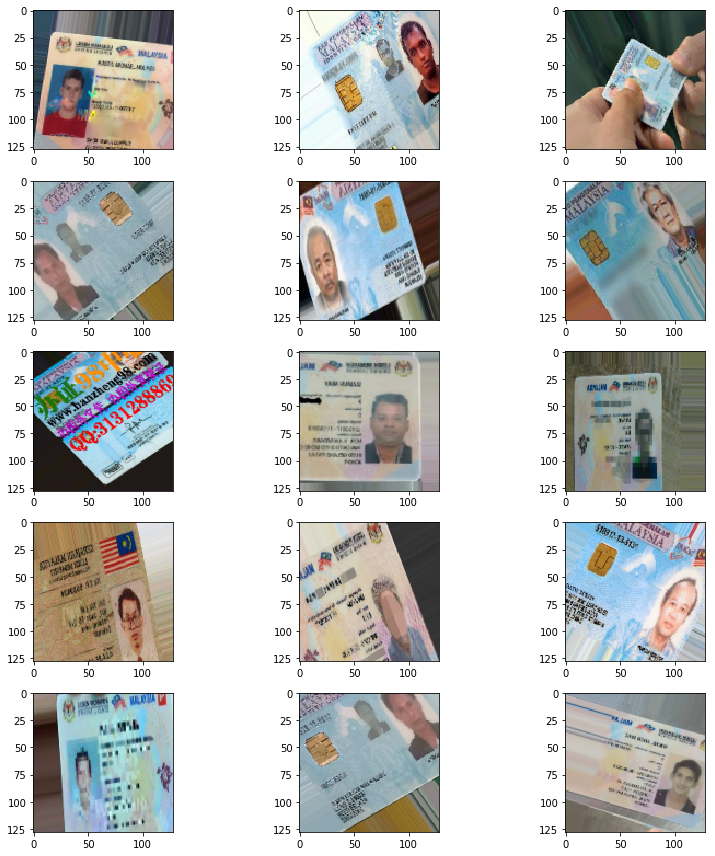

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# print 15 sample training image
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in training_set:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [6]:
# # Part 2 - Building the CNN
# # Importing the Keras libraries and packages
import time

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

# Use EarlyStopping and ReduceLROnPlateau
# when train, it keep testing set separetely and if the error is not improve for 5 times, training stop
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

# Save the best weight for epoch checkpoint
checkpointer = ModelCheckpoint(filepath = "best_weight.hdf5", monitor='val_loss', verbose=0, save_best_only=True) 


In [7]:
# Load the extension and start TensorBoard
%load_ext tensorboard.notebook
%tensorboard --logdir logs

In [8]:
from keras.optimizers import adam

print("Start training...")

STEP_SIZE_TRAIN = training_set.n//training_set.batch_size
STEP_SIZE_TEST = testing_set.n//testing_set.batch_size

# CONV_LAYERS = [1, 2, 3]
# LAYER_SIZES = [32, 64, 128]
# DENSE_LAYERS = [0, 1, 2]

CONV_LAYERS = [2]
LAYER_SIZES = [64]
DENSE_LAYERS = [2]

# CONV_LAYERS = [2]
# LAYER_SIZES = [64]
# DENSE_LAYERS = [0]

# Hyper-parameter tuning. Trial and Error
# Set Optimizer. Adam or RMSprop
# https://datascience.stackexchange.com/questions/43191/validation-loss-is-not-decreasing
opt = adam(lr=LR, decay=1e-6)

for dense_layer in DENSE_LAYERS:
    for layer_size in LAYER_SIZES:
        for conv_layer in CONV_LAYERS:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()
            
            # input layer 
            model.add(Conv2D(layer_size, (3, 3), input_shape = INPUT_SHAPE, activation = 'relu'))
            model.add(MaxPooling2D(pool_size = (POOL_SIZE, POOL_SIZE)))

            # hidden layer
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))
            
            # output layer
            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            callbacks = [earlystop, checkpointer, tensorboard]

            model.compile(loss='binary_crossentropy',
                          optimizer=opt,
                          metrics=['binary_accuracy'])
            
            model.summary()
            
            history = model.fit_generator(training_set, 
                                epochs = EPOCHS, 
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data = testing_set,
                                validation_steps=STEP_SIZE_TEST,
                                callbacks=callbacks)
            

Start training...
2-conv-64-nodes-2-dense-1570561876
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
d

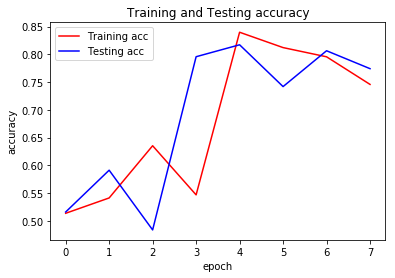

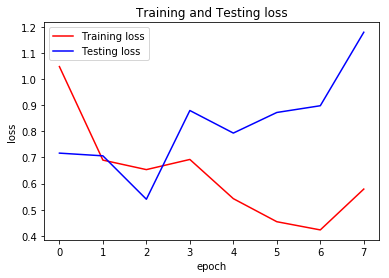

In [9]:
# plot history
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Testing acc')
plt.title('Training and Testing accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [10]:
print(model.metrics_names)
model.evaluate(testing_set)

['loss', 'binary_accuracy']
93/93 [==============================] - 1s 14ms/step


[1.1796026229858398, 0.774193525314331]

In [11]:
training_set.class_indices

{'driving_license': 0, 'identity_card': 1}

Confusion Matrix


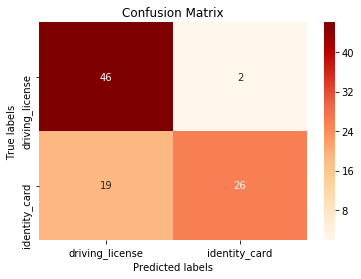

In [12]:
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

labels = testing_set.class_indices

Y_pred = model.predict_generator(testing_set, testing_set.n // testing_set.batch_size)
y_pred = np.where(Y_pred>0.5, 1, 0)

print('Confusion Matrix')
cm = confusion_matrix(testing_set.classes, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='OrRd'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


In [13]:
print('Classification Report')
print(classification_report(testing_set.classes, y_pred, target_names=labels))

Classification Report
                 precision    recall  f1-score   support

driving_license       0.71      0.96      0.81        48
  identity_card       0.93      0.58      0.71        45

       accuracy                           0.77        93
      macro avg       0.82      0.77      0.76        93
   weighted avg       0.81      0.77      0.76        93



In [14]:
# Part 3 - Making new prediction on single set

from keras.preprocessing import image
import numpy as np

test_image = image.load_img('../input/ic-driving-license-v2/single_prediction/test.jpg', target_size = INPUT_SHAPE)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

if result[0][0] == 1:
    prediction = 'ic'
else:
    prediction = 'driving'

print(prediction)

ic


In [15]:
# https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
from keras.models import load_model

model.save('model.h5') 

# deletes the existing model
# del model 

# returns a compiled model
# identical to the previous one
# model = load_model('model.h5')